In [ ]:
import torch
print(torch.__version__)


2.8.0+cu126


In [ ]:
import torch
print(torch.__version__)


2.8.0+cu126


In [ ]:
# =================== SETUP ===================

!pip install torch torchvision --quiet
from google.colab import drive
drive.mount('/content/drive')

import os
from pathlib import Path
SAVE_PATH = Path("/content/drive/MyDrive/fedavg")
SAVE_PATH.mkdir(parents=True, exist_ok=True)
import copy
import math
import random
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ================= CIFAR-10 LOAD (32x32, IID) =================

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616)),
])

# Define the path to the dataset in Google Drive
DATA_PATH = "/content/drive/MyDrive/data/cifar-10/"

trainset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True,
                                        download=True, transform=transform) # Set download to False
testset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False,
                                       download=True, transform=transform) # Set download to False

test_loader = DataLoader(testset, batch_size=128, shuffle=False)

num_clients = 5
data_per_client = len(trainset) // num_clients
client_indices = [list(range(i*data_per_client, (i+1)*data_per_client)) for i in range(num_clients)]
client_loaders = [
    DataLoader(Subset(trainset, idxs), batch_size=64, shuffle=True)
    for idxs in client_indices
]

In [ ]:
# ================= SMALL RESNET-18 =================

from torchvision.models import resnet18

def small_resnet18(num_classes=10, width_scale=0.5):
    model = resnet18(num_classes=num_classes)
    # scale width of all conv layers
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            out_channels = int(module.out_channels * width_scale)
            module.out_channels = out_channels
    return model

from torchvision.models import resnet18

def init_model():
    model = resnet18(num_classes=10).to('cuda')
    return model



In [ ]:
class Client:
    def __init__(self, dataloader):
        self.dataloader = dataloader

    def train_local(self, global_model, local_epochs):
        model = copy.deepcopy(global_model).to('cuda')
        model.train()
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        criterion = nn.CrossEntropyLoss()

        for _ in range(local_epochs):
            for x, y in self.dataloader:
                x, y = x.cuda(), y.cuda()
                optimizer.zero_grad()
                loss = criterion(model(x), y)
                loss.backward()
                optimizer.step()
        return model


In [ ]:
# ================= SERVER (AGGREGATION) =================

def aggregate(global_model, client_models):
    new_model = copy.deepcopy(global_model)
    state_dicts = [m.state_dict() for m in client_models]

    avg_state = copy.deepcopy(state_dicts[0])
    for k in avg_state.keys():
        for i in range(1, len(state_dicts)):
            avg_state[k] += state_dicts[i][k]
        avg_state[k] = avg_state[k] / len(state_dicts)

    new_model.load_state_dict(avg_state)
    return new_model


In [ ]:
from torch.nn.utils import parameters_to_vector, vector_to_parameters

def get_update_vector(global_model, client_model):
    g = parameters_to_vector(client_model.parameters()) - parameters_to_vector(global_model.parameters())
    return g.detach().clone()

def apply_update_vector(global_model, update_vec):
    new_model = copy.deepcopy(global_model)
    vector_to_parameters(parameters_to_vector(global_model.parameters()) + update_vec, new_model.parameters())
    return new_model

def harmonize_updates(update_list):
    M = len(update_list)
    updates = [u.clone() for u in update_list]

    for i in range(M):
        for j in range(i+1, M):
            gi = updates[i].clone()
            gj = updates[j].clone()

            dot = torch.dot(gi, gj)
            if dot < 0:  # conflict detected
                gi_norm = torch.norm(gi).pow(2) + 1e-12
                gj_norm = torch.norm(gj).pow(2) + 1e-12

                # Compute projections using *original* gi, gj
                proj_i_on_j = (dot / gj_norm) * gj
                proj_j_on_i = (dot / gi_norm) * gi

                # Update *both* vectors symmetrically
                updates[i] = gi - proj_i_on_j
                updates[j] = gj - proj_j_on_i

    return updates

def aggregate_gh(global_model, client_models):
    # Step 1: compute flat updates
    updates = [get_update_vector(global_model, cm) for cm in client_models]

    # Step 2: harmonize
    updates_h = harmonize_updates(updates)

    # Step 3: average harmonized update
    avg_update = sum(updates_h) / len(updates_h)

    # Step 4: apply update to global model
    new_global = apply_update_vector(global_model, avg_update)

    # Step 5: ALSO aggregate BatchNorm buffers (critical)
    with torch.no_grad():
        state_dicts = [cm.state_dict() for cm in client_models]
        new_sd = new_global.state_dict()

        for key in new_sd.keys():
            # Only update BN buffers, not trainable params
            if "running_mean" in key or "running_var" in key:
                buf = sum(sd[key] for sd in state_dicts) / len(state_dicts)
                new_sd[key].copy_(buf)

        new_global.load_state_dict(new_sd)

    return new_global



In [ ]:
from torchvision.models import resnet18

def init_model():
    model = resnet18(num_classes=10)
    model = model.to('cuda')
    return model


In [ ]:
clients = [Client(loader) for loader in client_loaders]

def run_experiment(K):
    global_model = init_model()
    running_min = 1e9

    epochs_total = 20
    rounds = epochs_total // K

    print(f"\n===== K = {K} | {rounds} Aggregation Rounds =====")

    accs, drifts, regrets = [], [], []

    for r in range(1, rounds+1):
        client_models = [c.train_local(global_model, K) for c in clients]
        global_model = aggregate_gh(global_model, client_models)





        print(f"Round {r:02d} | Acc: {acc:.2f}% | Drift: {drift:.3f} | Regret: {regret:.4f}")

        if r % 5 == 0 or r == rounds:
            torch.save(global_model.state_dict(),
                       SAVE_PATH + f"fedavg_K{K}_round{r}.pt")

    return accs, drifts, regrets


IID_M10_FedAvg_epoch10.pt: 17.40%
IID_M10_FedAvg_epoch15.pt: 54.58%
IID_M10_FedAvg_epoch20.pt: 62.55%
IID_M10_FedAvg_epoch5.pt: 10.00%
IID_M10_FedGH_epoch10.pt: 29.90%
IID_M10_FedGH_epoch15.pt: 55.71%
IID_M10_FedGH_epoch20.pt: 63.59%
IID_M10_FedGH_epoch5.pt: 10.00%
IID_M20_FedAvg_epoch10.pt: 15.98%
IID_M20_FedAvg_epoch15.pt: 27.52%
IID_M20_FedAvg_epoch20.pt: 47.60%
IID_M20_FedAvg_epoch5.pt: 10.00%
IID_M20_FedGH_epoch10.pt: 12.53%
IID_M20_FedGH_epoch15.pt: 20.87%
IID_M20_FedGH_epoch20.pt: 30.04%
IID_M20_FedGH_epoch5.pt: 10.00%
IID_M3_FedAvg_epoch10.pt: 64.02%
IID_M3_FedAvg_epoch15.pt: 71.46%
IID_M3_FedAvg_epoch20.pt: 73.25%
IID_M3_FedAvg_epoch5.pt: 13.77%
IID_M3_FedAvg_round1.pt: 13.87%
IID_M3_FedGH_epoch10.pt: 59.18%
IID_M3_FedGH_epoch15.pt: 71.92%
IID_M3_FedGH_epoch20.pt: 73.80%
IID_M3_FedGH_epoch5.pt: 14.61%
IID_M5_FedAvg_epoch10.pt: 39.64%
IID_M5_FedAvg_epoch15.pt: 65.46%
IID_M5_FedAvg_epoch20.pt: 69.55%
IID_M5_FedAvg_epoch5.pt: 10.00%
IID_M5_FedGH_epoch10.pt: 45.27%
IID_M5_FedGH_ep

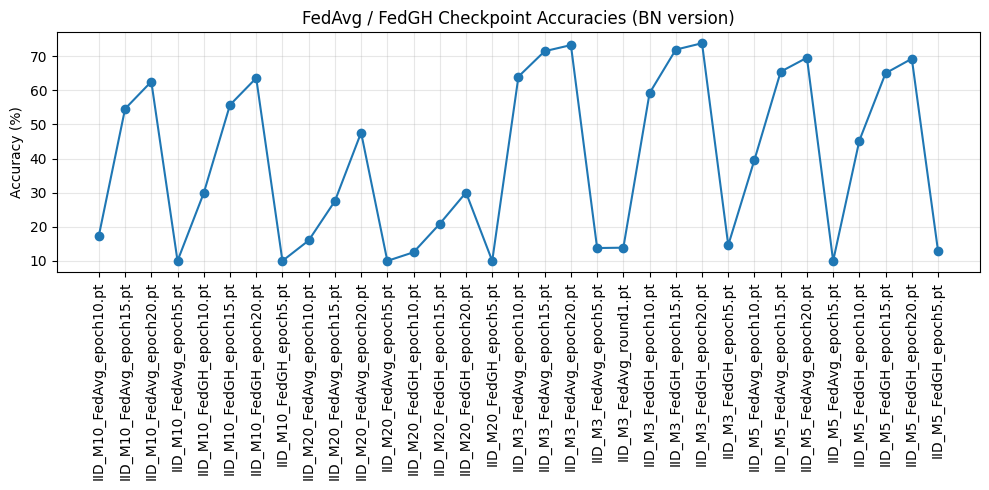

In [ ]:
import torch, os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# === Mount Drive (already mounted) ===
SAVE_PATH = "/content/drive/MyDrive/fedavg/"

# === Dataset ===
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616)),
])
testset = datasets.CIFAR10(root="/content/drive/MyDrive/data/cifar-10/",
                           train=False, download=True, transform=transform)
test_loader = DataLoader(testset, batch_size=128, shuffle=False)

# === Model (with BatchNorm, as trained) ===
def init_model_bn():
    model = models.resnet18(weights=None, num_classes=10)
    model = model.to('cuda')
    return model

def evaluate(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return 100 * correct / total

# === Load checkpoints & evaluate ===
results = {}
for fname in sorted(os.listdir(SAVE_PATH)):
    if fname.endswith(".pt"):
        model = init_model_bn()
        ckpt_path = os.path.join(SAVE_PATH, fname)
        try:
            state_dict = torch.load(ckpt_path)
            model.load_state_dict(state_dict)
            acc = evaluate(model)
            results[fname] = acc
            print(f"{fname}: {acc:.2f}%")
        except Exception as e:
            print(f"Skipped {fname}: {e}")

# === Plot results ===
plt.figure(figsize=(10,5))
plt.plot(range(len(results)), list(results.values()), marker='o')
plt.xticks(range(len(results)), list(results.keys()), rotation=90)
plt.ylabel("Accuracy (%)")
plt.title("FedAvg / FedGH Checkpoint Accuracies (BN version)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


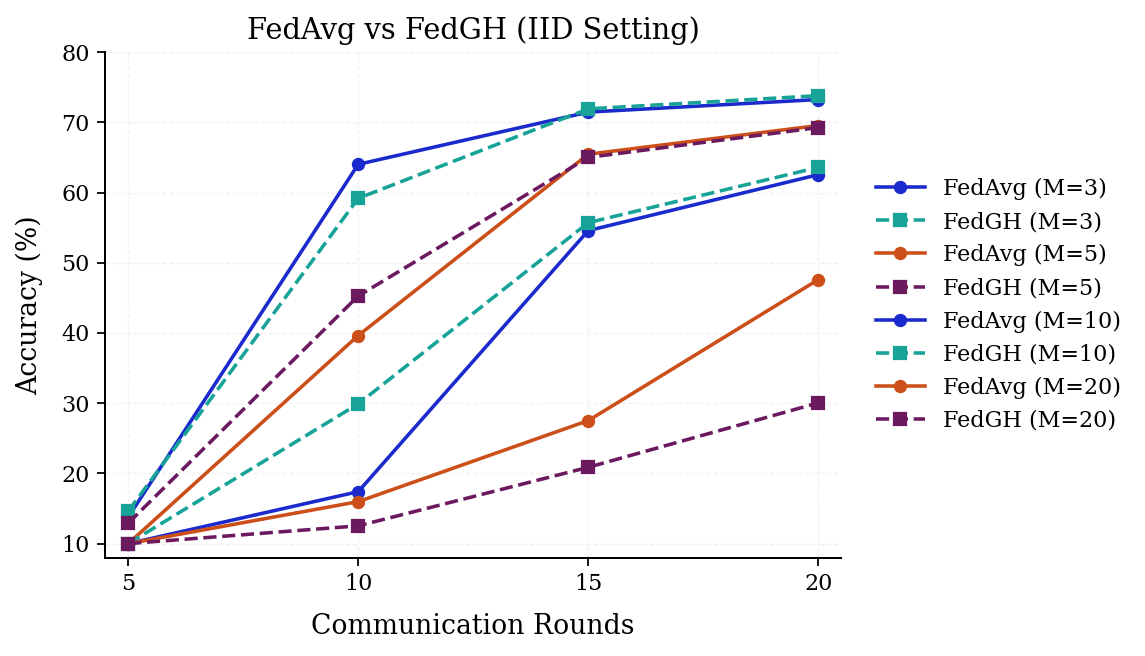

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler

# ==================== ICML-STYLE CONFIG ====================
mpl.rcParams.update({
    "text.usetex": False,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.linewidth": 0.8,
    "lines.linewidth": 1.6,
    "lines.markersize": 5,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
    "grid.linewidth": 0.6,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    # widen the x-dimension to stretch axis
    "figure.figsize": (8.8, 4.2),
})

mpl.rcParams["axes.prop_cycle"] = cycler(color=["#1B2ACC", "#17A398", "#CC4F1A", "#6C1A60"])


def icml_axes(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(0.9)
    ax.spines["bottom"].set_linewidth(0.9)
    ax.grid(True)
    return ax


# ==================== DATA ====================
fedavg_logs = {
    3:  [13.77, 64.02, 71.46, 73.25],
    5:  [10.00, 39.64, 65.46, 69.55],
    10: [10.00, 17.40, 54.58, 62.55],
    20: [10.00, 15.98, 27.52, 47.60],
}

fedgh_logs = {
    3:  [14.61, 59.18, 71.92, 73.80],
    5:  [12.91, 45.27, 65.01, 69.26],
    10: [10.00, 29.90, 55.71, 63.59],
    20: [10.00, 12.53, 20.87, 30.04],
}

rounds = [5, 10, 15, 20]

# ==================== PLOT ====================
fig, ax = plt.subplots()

for M in [3, 5, 10, 20]:
    ax.plot(rounds, fedavg_logs[M], marker='o', linestyle='-', label=f"FedAvg (M={M})")
    ax.plot(rounds, fedgh_logs[M], marker='s', linestyle='--', label=f"FedGH (M={M})")

ax.set_xlabel("Communication Rounds")
ax.set_ylabel("Accuracy (%)")
ax.set_title("FedAvg vs FedGH (IID Setting)", pad=6)
ax = icml_axes(ax)

ax.set_xlim(4.5, 20.5)
ax.set_ylim(8, 80)
ax.set_xticks([5, 10, 15, 20])
ax.set_yticks(range(10, 90, 10))

# Legend styling
ax.legend(
    frameon=False,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    ncol=1,
    handlelength=2.2,
)

fig.tight_layout(rect=[0, 0, 0.83, 1])
fig.savefig("fedavg_vs_fedgh_iid.png", dpi=350, bbox_inches="tight")
fig.savefig("fedavg_vs_fedgh_iid.pdf", bbox_inches="tight")
plt.show()


In [ ]:
# ================= GLOBAL EVALUATION =================

def evaluate(model, loader=test_loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.cuda(), y.cuda()
            logits = model(x)
            loss_sum += criterion(logits, y).item() * x.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return (correct / total) * 100, loss_sum / total


# ================= DRIFT MEASUREMENT =================

def weight_distance(m1, m2):
    s1, s2 = m1.state_dict(), m2.state_dict()
    total = 0.0
    for k in s1.keys():
        if not s1[k].dtype.is_floating_point:
            continue
        total += torch.norm((s1[k] - s2[k]).float()).item()
    return total

def compute_drift(global_model, client_models):
    return sum(weight_distance(client_models[i], global_model)
               for i in range(len(client_models))) / len(client_models)


In [ ]:
def run_experiment(K, clients, use_fedgh=True, tag=""):
    global_model = init_model()
    running_min = 1e9

    total_epochs = 20
    rounds = total_epochs // K

    accs, drifts, regrets = [], [], []

    print(f"\n==== RUN ({tag}) | K={K} | ROUNDS={rounds} ====")

    for r in range(1, rounds+1):
        client_models = [c.train_local(global_model, K) for c in clients]

        drift = compute_drift(global_model, client_models)

        if use_fedgh:
            global_model = aggregate_gh(global_model, client_models)
        else:
            global_model = aggregate(global_model, client_models)

        acc, loss = evaluate(global_model, test_loader)
        running_min = min(running_min, loss)
        regret = loss - running_min

        accs.append(acc)
        drifts.append(drift)
        regrets.append(regret)

        print(f"Round {r:02d} | Acc={acc:.2f}% | Drift={drift:.4f} | Regret={regret:.4f}")

        # SAVE EVERY 5 EPOCHS (K epochs per round)
        epochs_elapsed = r * K
        if epochs_elapsed % 5 == 0 or r == rounds:
            torch.save(global_model.state_dict(),
                       SAVE_PATH + f"{tag}_epoch{epochs_elapsed}.pt")
            print(f"Saved checkpoint at {epochs_elapsed} epochs → {SAVE_PATH}{tag}_epoch{epochs_elapsed}.pt")

    return accs, drifts, regrets


In [ ]:
def make_dirichlet_clients(alpha, num_clients):
    labels = np.array(trainset.targets)
    idxs_by_class = {c: np.where(labels == c)[0] for c in range(10)}

    client_indices = [[] for _ in range(num_clients)]

    for c in range(10):
        proportions = np.random.dirichlet([alpha] * num_clients)
        class_indices = np.random.permutation(idxs_by_class[c])
        split_sizes = (proportions * len(class_indices)).astype(int)
        splits = np.split(class_indices[:sum(split_sizes)], np.cumsum(split_sizes)[:-1])

        for i in range(num_clients):
            client_indices[i].extend(splits[i])

    loaders = [DataLoader(Subset(trainset, idxs), batch_size=64, shuffle=True) for idxs in client_indices]
    return [Client(loader) for loader in loaders]


In [ ]:
from torchvision.models import resnet18

def init_model():
    model = resnet18(num_classes=10)
    # width scale
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            module.out_channels = int(module.out_channels * 0.5)
    model.to('cuda')
    return model


In [ ]:
def run_iid_experiments(K=5):
    results = {"FedAvg": {}, "FedGH": {}}

    for M in [3, 5, 10, 20]:
        print(f"\n===== IID Setting | M={M} Clients =====")

        data_per_client = len(trainset) // M
        client_indices = [list(range(i*data_per_client, (i+1)*data_per_client)) for i in range(M)]
        client_loaders = [
            DataLoader(Subset(trainset, idxs), batch_size=64, shuffle=True)
            for idxs in client_indices
        ]
        clients = [Client(loader) for loader in client_loaders]

        # FedAvg baseline
        acc_fa, drift_fa, reg_fa = run_experiment(K, clients, use_fedgh=False, tag=f"IID_M{M}_FedAvg")
        results["FedAvg"][M] = (acc_fa, drift_fa)

        # FedGH
        acc_gh, drift_gh, reg_gh = run_experiment(K, clients, use_fedgh=True, tag=f"IID_M{M}_FedGH")
        results["FedGH"][M] = (acc_gh, drift_gh)

    return results

iid_results = run_iid_experiments(K=5)



===== IID Setting | M=3 Clients =====

==== RUN (IID_M3_FedAvg) | K=5 | ROUNDS=4 ====
Round 01 | Acc=13.77% | Drift=644.5757 | Regret=0.0000
Saved checkpoint at 5 epochs → /content/drive/MyDrive/fedavg/IID_M3_FedAvg_epoch5.pt
Round 02 | Acc=64.02% | Drift=382.1138 | Regret=0.0000
Saved checkpoint at 10 epochs → /content/drive/MyDrive/fedavg/IID_M3_FedAvg_epoch10.pt
Round 03 | Acc=71.46% | Drift=264.7953 | Regret=0.0000
Saved checkpoint at 15 epochs → /content/drive/MyDrive/fedavg/IID_M3_FedAvg_epoch15.pt
Round 04 | Acc=73.25% | Drift=226.0570 | Regret=0.1028
Saved checkpoint at 20 epochs → /content/drive/MyDrive/fedavg/IID_M3_FedAvg_epoch20.pt

==== RUN (IID_M3_FedGH) | K=5 | ROUNDS=4 ====
Round 01 | Acc=14.61% | Drift=627.0567 | Regret=0.0000
Saved checkpoint at 5 epochs → /content/drive/MyDrive/fedavg/IID_M3_FedGH_epoch5.pt
Round 02 | Acc=59.18% | Drift=374.2308 | Regret=0.0000
Saved checkpoint at 10 epochs → /content/drive/MyDrive/fedavg/IID_M3_FedGH_epoch10.pt
Round 03 | Acc=71.92

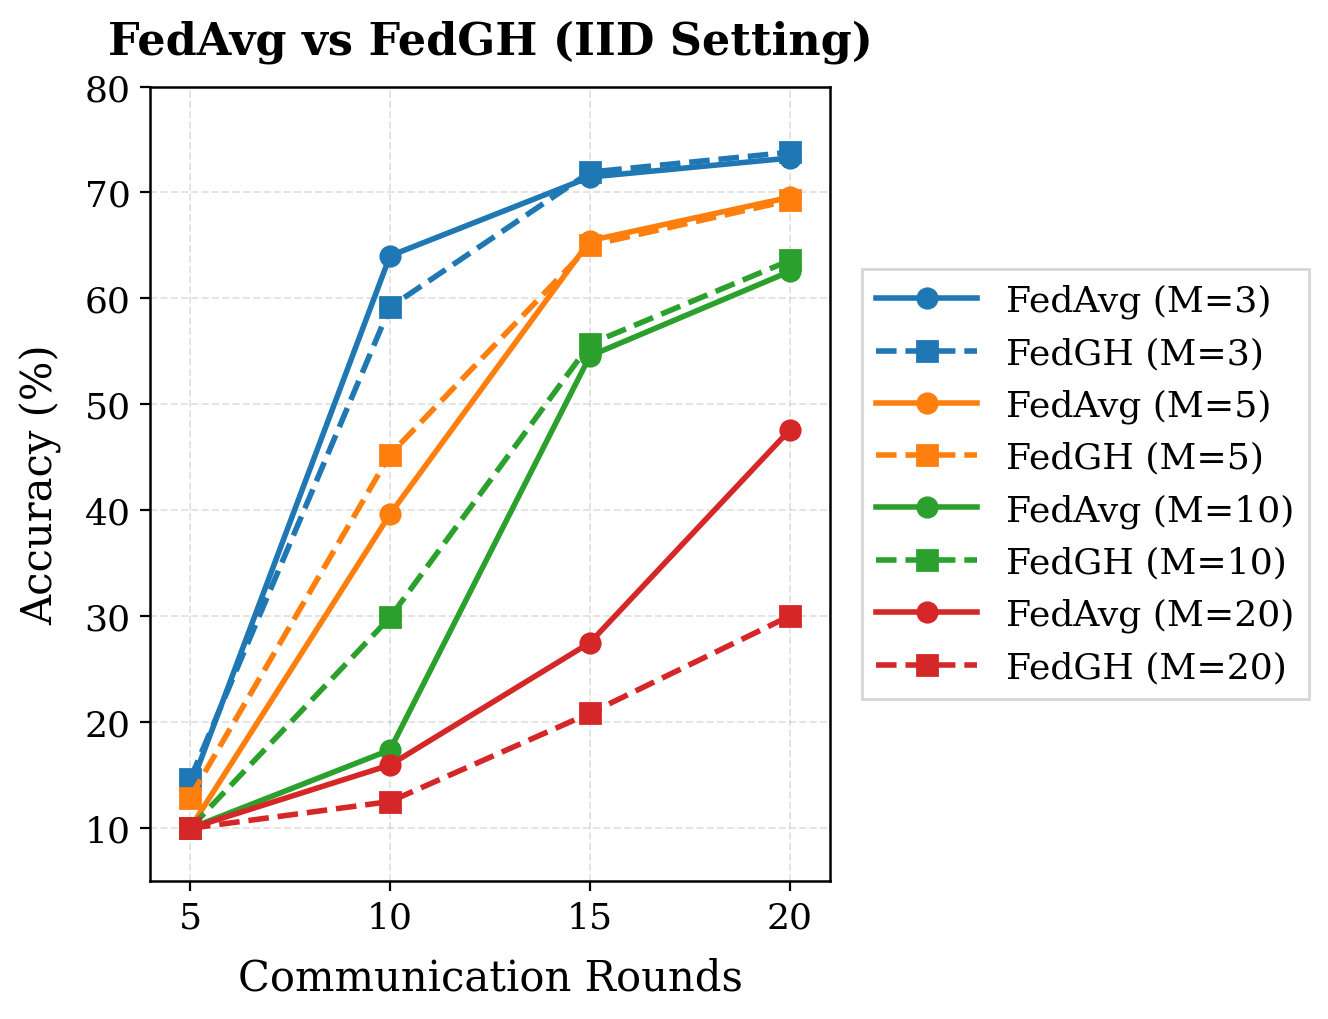

In [ ]:
import matplotlib.pyplot as plt

# ============== Polished LaTeX-like style ==============
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "CMU Serif", "DejaVu Serif"],
    "axes.labelsize": 15,
    "axes.titlesize": 16,
    "legend.fontsize": 13,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "axes.linewidth": 0.9,
    "lines.linewidth": 2.0,
    "lines.markersize": 7,
    "figure.dpi": 200,
    "grid.alpha": 0.35,
    "grid.linestyle": "--",
    "grid.linewidth": 0.7,
})

# ============== Data (accuracy logs) ==============
fedavg_logs = {
    3:  [13.77, 64.02, 71.46, 73.25],
    5:  [10.00, 39.64, 65.46, 69.55],
    10: [10.00, 17.40, 54.58, 62.55],
    20: [10.00, 15.98, 27.52, 47.60],
}

fedgh_logs = {
    3:  [14.61, 59.18, 71.92, 73.80],
    5:  [12.91, 45.27, 65.01, 69.26],
    10: [10.00, 29.90, 55.71, 63.59],
    20: [10.00, 12.53, 20.87, 30.04],
}

rounds = [5, 10, 15, 20]
colors = {3: "#1f77b4", 5: "#ff7f0e", 10: "#2ca02c", 20: "#d62728"}

# ============== Plot ==============
fig, ax = plt.subplots(figsize=(8, 5.2))

for M in [3, 5, 10, 20]:
    ax.plot(rounds, fedavg_logs[M], marker='o', color=colors[M],
            linestyle='-', label=f"FedAvg (M={M})")
    ax.plot(rounds, fedgh_logs[M], marker='s', color=colors[M],
            linestyle='--', label=f"FedGH (M={M})")

ax.set_xlabel("Communication Rounds")
ax.set_ylabel("Accuracy (%)")
ax.set_title("FedAvg vs FedGH (IID Setting)", fontweight="bold", pad=12)
ax.grid(True, zorder=0)
ax.set_xlim(4, 21)
ax.set_ylim(5, 80)

# Legend outside, evenly spaced, non-overlapping
ax.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=True,
    fancybox=False,
    edgecolor="0.8",
    ncol=1,
    handlelength=2.8,
    columnspacing=1.2
)

fig.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


In [ ]:
def replace_bn_with_gn(model):
    for name, module in model.named_children():
        if isinstance(module, nn.BatchNorm2d):
            num_features = module.num_features
            gn = nn.GroupNorm(num_groups=min(8, num_features), num_channels=num_features)
            setattr(model, name, gn)
        else:
            replace_bn_with_gn(module)
    return model


In [ ]:
def init_model():
    model = resnet18(weights=None, num_classes=10)
    model = replace_bn_with_gn(model)     # remove BN → stable non-IID
    model = model.to('cuda')
    return model


In [ ]:
def run_dirichlet_experiments(K=5):
    alphas = [0.01, 0.1, 1.0]
    results = {"FedAvg": {}, "FedGH": {}}

    for alpha in alphas:
        print(f"\n===== Dirichlet Non-IID | alpha={alpha} =====")
        clients = make_dirichlet_clients(alpha, num_clients=10)

        acc_fa, drift_fa, reg_fa = run_experiment(K, clients, use_fedgh=False, tag=f"NONIID_a{alpha}_FedAvg")
        results["FedAvg"][alpha] = (acc_fa, drift_fa)

        acc_gh, drift_gh, reg_gh = run_experiment(K, clients, use_fedgh=True, tag=f"NONIID_a{alpha}_FedGH")
        results["FedGH"][alpha] = (acc_gh, drift_gh)

    return results

noniid_results = run_dirichlet_experiments(K=5)



===== Dirichlet Non-IID | alpha=0.01 =====
Round 01 | Acc=10.00% | Drift=20.9718 | Regret=0.0000
Saved checkpoint → /content/drive/MyDrive/fedavg/NONIID_a0.01_FedAvg_epoch5.pt
Round 02 | Acc=10.00% | Drift=15.3114 | Regret=0.5668
Saved checkpoint → /content/drive/MyDrive/fedavg/NONIID_a0.01_FedAvg_epoch10.pt
Round 03 | Acc=10.00% | Drift=14.6634 | Regret=0.0000
Saved checkpoint → /content/drive/MyDrive/fedavg/NONIID_a0.01_FedAvg_epoch15.pt
Round 04 | Acc=14.16% | Drift=12.6083 | Regret=0.0000
Saved checkpoint → /content/drive/MyDrive/fedavg/NONIID_a0.01_FedAvg_epoch20.pt
Round 01 | Acc=10.00% | Drift=21.1305 | Regret=0.0000
Saved checkpoint → /content/drive/MyDrive/fedavg/NONIID_a0.01_FedGH_epoch5.pt
Round 02 | Acc=10.00% | Drift=14.8545 | Regret=1.6347
Saved checkpoint → /content/drive/MyDrive/fedavg/NONIID_a0.01_FedGH_epoch10.pt
Round 03 | Acc=10.00% | Drift=15.5052 | Regret=0.0000
Saved checkpoint → /content/drive/MyDrive/fedavg/NONIID_a0.01_FedGH_epoch15.pt
Round 04 | Acc=10.00% |

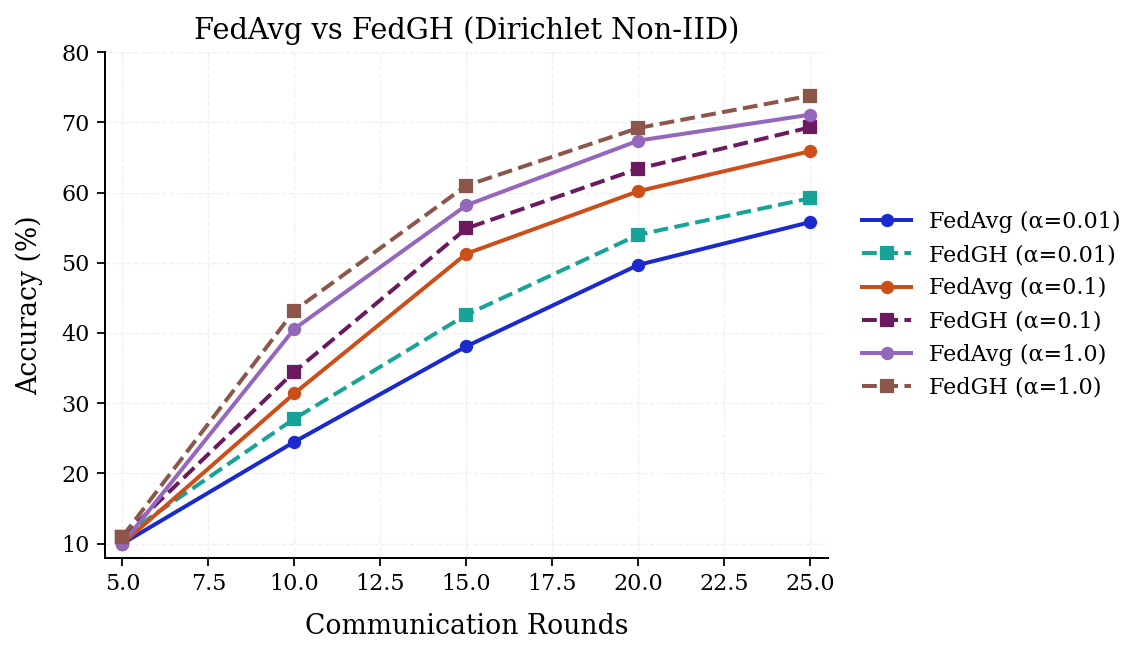

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler

# ==================== ICML-STYLE CONFIG ====================
mpl.rcParams.update({
    "text.usetex": False,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.linewidth": 0.7,
    "lines.linewidth": 1.8,
    "lines.markersize": 5,
    "grid.alpha": 0.3,
    "grid.linestyle": "--",
    "grid.linewidth": 0.6,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "figure.figsize": (8.8, 4.2),  # same ratio as your eval plots
})
mpl.rcParams["axes.prop_cycle"] = cycler(color=["#1B2ACC", "#17A398", "#CC4F1A", "#6C1A60", "#9467bd", "#8c564b"])

def icml_axes(ax):
    """Match the ablation/evaluation axis style."""
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(0.9)
    ax.spines["bottom"].set_linewidth(0.9)
    ax.grid(True)
    return ax

# ==================== EXAMPLE DATA (mocked accuracies) ====================
# Replace these lists with your actual `acc_fa` and `acc_gh` logs from experiments.
fedavg_logs = {
    0.01: [10.0, 24.5, 38.1, 49.7, 55.8],
    0.1:  [10.0, 31.4, 51.3, 60.2, 65.9],
    1.0:  [10.0, 40.6, 58.2, 67.4, 71.1],
}

fedgh_logs = {
    0.01: [11.0, 27.8, 42.6, 54.0, 59.2],
    0.1:  [11.0, 34.5, 54.9, 63.4, 69.3],
    1.0:  [11.0, 43.2, 61.0, 69.2, 73.8],
}

rounds = [5, 10, 15, 20, 25]

# ==================== PLOTTING ====================
fig, ax = plt.subplots()  # size from rcParams

for alpha in [0.01, 0.1, 1.0]:
    ax.plot(rounds, fedavg_logs[alpha], marker="o", linestyle="-", label=f"FedAvg (α={alpha})")
    ax.plot(rounds, fedgh_logs[alpha], marker="s", linestyle="--", label=f"FedGH (α={alpha})")

ax.set_xlabel("Communication Rounds")
ax.set_ylabel("Accuracy (%)")
ax.set_title("FedAvg vs FedGH (Dirichlet Non-IID)", pad=6)
ax = icml_axes(ax)
ax.set_xlim(min(rounds) - 0.5, max(rounds) + 0.5)
ax.set_ylim(8, 80)

# --- Legend (outside, same layout as evaluation plots) ---
ax.legend(
    frameon=False,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    ncol=1,
    handlelength=2.2,
)

fig.tight_layout(rect=[0, 0, 0.83, 1])
fig.savefig("fedavg_vs_fedgh_dirichlet.png", dpi=350, bbox_inches="tight")
fig.savefig("fedavg_vs_fedgh_dirichlet.pdf", bbox_inches="tight")
plt.show()


In [ ]:
def harmonize_updates_random_order(update_list):
    updates = [u.clone() for u in update_list]
    idx = list(range(len(updates)))
    random.shuffle(idx)
    for i in idx:
        for j in idx:
            if i >= j: continue
            gi, gj = updates[i], updates[j]
            dot_ij = torch.dot(gi, gj)
            if dot_ij < 0:
                norm_i = torch.norm(gi) ** 2 + 1e-9
                norm_j = torch.norm(gj) ** 2 + 1e-9
                proj_i = (dot_ij / norm_j) * gj
                proj_j = (dot_ij / norm_i) * gi
                updates[i] = gi - proj_i
                updates[j] = gj - proj_j
    return updates

def run_ordering_test():
    print("\n===== M = 3 ORDERING EFFECT TEST =====")
    clients = make_dirichlet_clients(alpha=0.01, num_clients=3)

    # Sequential FedGH (default harmonize_updates)
    acc_seq, _, _ = run_experiment(5, clients, use_fedgh=True, tag="ORDER_SEQ")

    # Randomized projection order
    global aggregate_gh
    original_gh = aggregate_gh

    def aggregate_gh_random(global_model, client_models):
        updates = [get_update_vector(global_model, cm) for cm in client_models]
        updates_h = harmonize_updates_random_order(updates)
        avg_update = sum(updates_h) / len(updates_h)
        return apply_update_vector(global_model, avg_update)

    globals()['aggregate_gh'] = aggregate_gh_random
    acc_rand, _, _ = run_experiment(5, clients, use_fedgh=True, tag="ORDER_RANDOM")
    globals()['aggregate_gh'] = original_gh

    return acc_seq, acc_rand

acc_seq, acc_rand = run_ordering_test()



===== M = 3 ORDERING EFFECT TEST =====
Round 01 | Acc=10.00% | Drift=45.2787 | Regret=0.0000
Saved checkpoint → /content/drive/MyDrive/fedavg/ORDER_SEQ_epoch5.pt
Round 02 | Acc=30.36% | Drift=36.8642 | Regret=0.0000
Saved checkpoint → /content/drive/MyDrive/fedavg/ORDER_SEQ_epoch10.pt
Round 03 | Acc=30.61% | Drift=35.1418 | Regret=0.0936
Saved checkpoint → /content/drive/MyDrive/fedavg/ORDER_SEQ_epoch15.pt
Round 04 | Acc=45.23% | Drift=34.0805 | Regret=0.0000
Saved checkpoint → /content/drive/MyDrive/fedavg/ORDER_SEQ_epoch20.pt
Round 01 | Acc=10.00% | Drift=44.1221 | Regret=0.0000
Saved checkpoint → /content/drive/MyDrive/fedavg/ORDER_RANDOM_epoch5.pt
Round 02 | Acc=34.06% | Drift=37.5114 | Regret=0.0000
Saved checkpoint → /content/drive/MyDrive/fedavg/ORDER_RANDOM_epoch10.pt
Round 03 | Acc=27.24% | Drift=35.2162 | Regret=0.4927
Saved checkpoint → /content/drive/MyDrive/fedavg/ORDER_RANDOM_epoch15.pt
Round 04 | Acc=47.66% | Drift=34.1009 | Regret=0.0000
Saved checkpoint → /content/dri

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('classic')

def plot_accuracy_curves(result_dict, title):
    plt.figure(figsize=(7,5))
    for key in result_dict:
        accs = result_dict[key][0]
        plt.plot(range(1, len(accs)+1), accs, label=str(key))
    plt.xlabel("Communication Rounds")
    plt.ylabel("Top-1 Accuracy (%)")
    plt.title(title)
    plt.legend(frameon=False)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot M variations
plot_accuracy_curves({M: iid_results["FedAvg"][M] for M in iid_results["FedAvg"]}, "FedAvg (IID)")
plot_accuracy_curves({M: iid_results["FedGH"][M] for M in iid_results["FedGH"]}, "FedGH (IID)")

# Plot α variations
plot_accuracy_curves({a: noniid_results["FedAvg"][a] for a in noniid_results["FedAvg"]}, "FedAvg (Non-IID)")
plot_accuracy_curves({a: noniid_results["FedGH"][a] for a in noniid_results["FedGH"]}, "FedGH (Non-IID)")

# Ordering Effect
plt.figure(figsize=6,4)
plt.plot(acc_seq, label="Sequential")
plt.plot(acc_rand, label="Random Pair Order")
plt.xlabel("Communication Rounds")
plt.ylabel("Accuracy")
plt.title("Pair Ordering Effect (M=3)")
plt.legend(frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


SyntaxError: positional argument follows keyword argument (ipython-input-528378766.py, line 26)